##  Class of data preprocessing

In [25]:
import pandas as pd
import numpy as np

class Data_Preprocessing():
    
    def __init__(self, prefix = '../../data/'):
        self.prefix = prefix
        self.diagnoses = None
        self.measures = None
    
    # Descriptions of different kinds of diseases based on ICD_CODE
    def get_icd9codes(self,filename='D_ICD_DIAGNOSES.csv'):
        icd9_code_df = pd.read_csv(self.prefix+filename, sep=',', encoding='latin1')
        return icd9_code_df

    # Information about what diseases patients are diagnosed
    def read_diagnoses(self,filename='DIAGNOSES_ICD.csv',
                       link_filename = 'D_ICD_DIAGNOSES.csv',link_field='ICD9_CODE',
                      columns = ['SUBJECT_ID','ICD9_CODE','SHORT_TITLE','LONG_TITLE']):
        diagnose_df = pd.read_csv(self.prefix+filename, sep=',', encoding='latin1')
        diagnose_df = pd.merge(diagnose_df, self.get_icd9codes(link_filename), how='left', on=[link_field])
        self.diagnoses = diagnose_df[columns]
        
    # Pick data of specific diseases from diagnoses data
    # 4280 Congestive heart failure
    def get_labels(self, label_filed = 'ICD9_CODE', labels = ['4280'], user_field = 'SUBJECT_ID'):
        if self.diagnoses is None:
            print('Please use read_diagnoses function to get diagnose data first')
            return False
        else:
            ## TODO: What if it is required to process multiple diseases?
            filtered_diseass = self.diagnoses[self.diagnoses[label_filed].isin(labels)].drop_duplicates()
            filtered_diseass['LABEL'] = 1
            return filtered_diseass[[user_field,'LABEL']]
        
    
    # Descriptions of different kinds of clinical measurements
    def get_measure_items(self,filename='D_LABITEMS.csv'):
        measure_items_df = pd.read_csv(self.prefix+filename, sep=',', encoding='latin1')
        return measure_items_df
    
    # Information about what measurements patients have and values of those measurements -> attributes
    def read_measurements(self,filename = 'LABEVENTS.csv',columns = ['SUBJECT_ID','VALUE','VALUENUM','LABEL']):
        measurements_df = pd.read_csv(self.prefix+filename, sep=',', encoding='latin1')
        measurements_df = pd.merge(measurements_df, self.get_measure_items(), how='left', on=['ITEMID'])[columns]
        self.measures = measurements_df
    
    # min_null: fields with none values more than 80% are categorical fields, otherwise continous fields.
    def get_user_vectors(self, fields= ['VALUE','LABEL','VALUENUM','SUBJECT_ID'], min_nulls = 0.8, max_labels=4):
        value = fields[0]
        label = fields[1]
        valuenum = fields[2]
        userid = fields[3]
        labels_nulls = self.measures.dropna(subset=[value]).groupby(label)[valuenum].apply(lambda x: x.isnull().sum())
        
        # initiate all user vectors
        len_all_measures = len(self.measures)
        stc_ls = ['min','mean','max','std']
        stc_ls_len = len(stc_ls)
        user_vectors = {}
        all_users = set(self.measures[userid].unique())
        for user in all_users:
            user_vectors[user] = np.empty([0])
            
        # Groupby label
        measure_label = self.measures.groupby(label)
        i = 1
        for label, label_df in measure_label:
            if i>max_labels: break
            # continuous
            if ((labels_nulls[label]/len_all_measures)<min_nulls):
                # pick one iteration of continuous label
                label_df = label_df.dropna(subset=[valuenum])
#                 print(label_df[:10])
                missed_users = all_users -set(label_df[userid].unique())
                label_df_agg = label_df.groupby(userid)[valuenum].agg(stc_ls)

                for user, row in label_df_agg.iterrows():
                    if pd.isnull(row['std']): row['std']=0
                    user_vectors[user]=np.append(user_vectors[user],[row[x] for x in stc_ls])
                for user in missed_users:
                    user_vectors[user]=np.append(user_vectors[user],np.full(stc_ls_len, np.nan))
            
            else:
                # pick one iteration of discrete label
                label_df = label_df.dropna(subset=[value])
                missed_users = all_users - set(label_df[user].unique())
                label_df_agg = label_df.groupby([userid,value])[label].agg(['count'])
                label_df_agg_per = label_df_agg.groupby(level=0).apply(lambda x: 100* x/float(x.sum()))

                label_df_agg_per.reset_index
                label_matrix = pd.pivot_table(label_df_agg_per,
                                              values = ['count'],index=[userid],columns=[value]).fillna(0)

                for user in label_matrix.index.get_level_values(userid):
                    user_vectors[user] = np.append(user_vectors[user],label_matrix.ix[user].values)
                for user in missed_users:
                    user_vectors[user]=np.append(user_vectors[user],np.full(label_matrix.shape[1], np.nan))
            i+=1
                    
        return user_vectors
                

## read diagnose information

In [26]:
data_preprocessing = Data_Preprocessing()
# data_preprocessing.read_diagnoses()
# data_preprocessing.diagnoses.head()

In [54]:
data_preprocessing.get_labels().head()

Please use read_diagnoses function to get diagnose data first


AttributeError: 'bool' object has no attribute 'head'

## Feature Data (Use Labevents rather than Charevents)

In [22]:
data_preprocessing.read_measurements()
user_vectors = data_preprocessing.get_user_vectors()
# labevent_items_df = pd.read_csv('../../data/D_LABITEMS.csv', sep=',', encoding='latin1')
# labevent_cols = ['SUBJECT_ID','VALUE','VALUENUM','LABEL']
# labevent_detailed_df = pd.merge(labevent_df, labevent_items_df, how='left', on=['ITEMID'])[labevent_cols]
# labevent_detailed_df.sort_values(by='SUBJECT_ID')[:10]

       SUBJECT_ID VALUE  VALUENUM             LABEL
2494            4   7.4       7.4  % Hemoglobin A1c
4409            9   5.6       5.6  % Hemoglobin A1c
7931           17   5.2       5.2  % Hemoglobin A1c
8533           18   6.3       6.3  % Hemoglobin A1c
8866           18   6.9       6.9  % Hemoglobin A1c
10311          23   5.5       5.5  % Hemoglobin A1c
11623          28   6.6       6.6  % Hemoglobin A1c
12422          30   6.6       6.6  % Hemoglobin A1c
12551          36   5.1       5.1  % Hemoglobin A1c
13528          35   7.6       7.6  % Hemoglobin A1c


In [14]:
user_vectors[775]
# Assign index to measurement item

# label_array = labevent_detailed_df['LABEL'].unique() 
# label_map = {}

# for i in range(0,len(label_array)):
#     label_map[label_array[i]] = i


array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan])

In [163]:
len(test)
len(test.dropna(axis=0,how='all'))

10111

In [180]:
# user_vectors[2]
# test = pd.DataFrame(user_vectors).T.dropna(axis=0,how='all')
# dctToNdarray
pd.DataFrame({'SS':test.index})

In [165]:
test_nona = test.fillna(test.mean())
test_nona.head()

0    1    2         3          4           5           6          7   \
4   7.4  7.4  7.4  0.000000  150.84058  159.663147  170.391304  11.857041   
9   5.6  5.6  5.6  0.000000  150.84058  159.663147  170.391304  11.857041   
17  5.2  5.2  5.2  0.000000  150.84058  159.663147  170.391304  11.857041   
18  6.3  6.6  6.9  0.424264  150.84058  159.663147  170.391304  11.857041   
23  5.5  5.5  5.5  0.000000  150.84058  159.663147  170.391304  11.857041   

            8           9     ...             14          15         16  \
4   866.338912  914.671384    ...     2516.90303  321.798923  21.333333   
9   866.338912  914.671384    ...     2516.90303  321.798923  21.333333   
17  866.338912  914.671384    ...     2516.90303  321.798923  21.333333   
18  866.338912  914.671384    ...     2516.90303  321.798923  21.333333   
23  866.338912  914.671384    ...     2516.90303  321.798923  21.333333   

           17        18        19     20         21         22        23  
4   21.536232  21.73913  0.286942  53.26  53.371667  53.483333  0.157921  
9   21.536232  21.73913  0.286942  53.26  53.371667  53.483333  0.157921  
17  21.536232  21.73913  0.286942  53.26  53.371667  53.483333  0.157921  
18  21.536232  21.73913  0.286942  53.26  53.371667  53.483333  0.157921  
23  21.536232  21.73913  0.286942  53.26  53.371667  53.483333  0.157921  

[5 rows x 24 columns]

In [166]:
data_preprocessing.read_diagnoses()
actual_label = data_preprocessing.get_labels()

In [167]:
actual_label.sort_values(by='SUBJECT_ID').head()


SUBJECT_ID  LABEL
616           3      1
651           9      1
724          21      1
793          26      1
844          34      1

In [168]:
all_users_list = pd.DataFrame({'SUBJECT_ID': test.index})
all_users_list.head()

SUBJECT_ID
0           4
1           9
2          17
3          18
4          23

In [169]:
# len(all_users_list)
actual_labels = pd.merge(all_users_list,actual_label,how='left',on='SUBJECT_ID')
len(actual_labels)

10111

In [170]:
actual_labels = actual_labels.fillna(0)
actual_labels.head()

SUBJECT_ID  LABEL
0           4    0.0
1           9    1.0
2          17    0.0
3          18    0.0
4          23    0.0

In [177]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=0).fit(test_nona)
kmeans.labels_

kmeans.cluster_centers_

y_pred = KMeans(n_clusters=2, random_state=0).fit_predict(test_nona)
y_pred
from collections import Counter
Counter(y_pred).values()
# list(set(y_pred))

dict_values([10109, 2])

In [59]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, learning_rate=3000).fit_transform(test_nona)

plt.figure(figsize=(15, 15))
plt.scatter(X_embedded[:,0],X_embedded[:,1],c=y_pred)
plt.title("KMeans")
plt.show()

In [58]:
import umap
# from sklearn.datasets import load_digits

# digits = load_digits()

embedding = umap.UMAP().fit_transform(test_nona)

/anaconda3/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 20 separate connected components using meta-embedding (experimental)
  n_components


In [187]:
# actual_labels['LABEL'] = actual_labels['LABEL'].astype(int)
# actual_labels['PREDICTED']=y_pred
# actual_labels['X0']=embedding[:,0]
# actual_labels['X1']=embedding[:,1]
# actual_labels[:10]
# # pd.concat([y_pred, actual_labels['LABEL'].astype(int)],axis=1).head()
# # embedding.tolist()
# true_X = actual_labels[actual_labels['LABEL']==0]
# false_X = actual_labels[actual_labels['LABEL']==1]
# true_X.head()
true_X['LABEL'].head()

0    0
2    0
3    0
4    0
5    0
Name: LABEL, dtype: int64

In [181]:
false_X

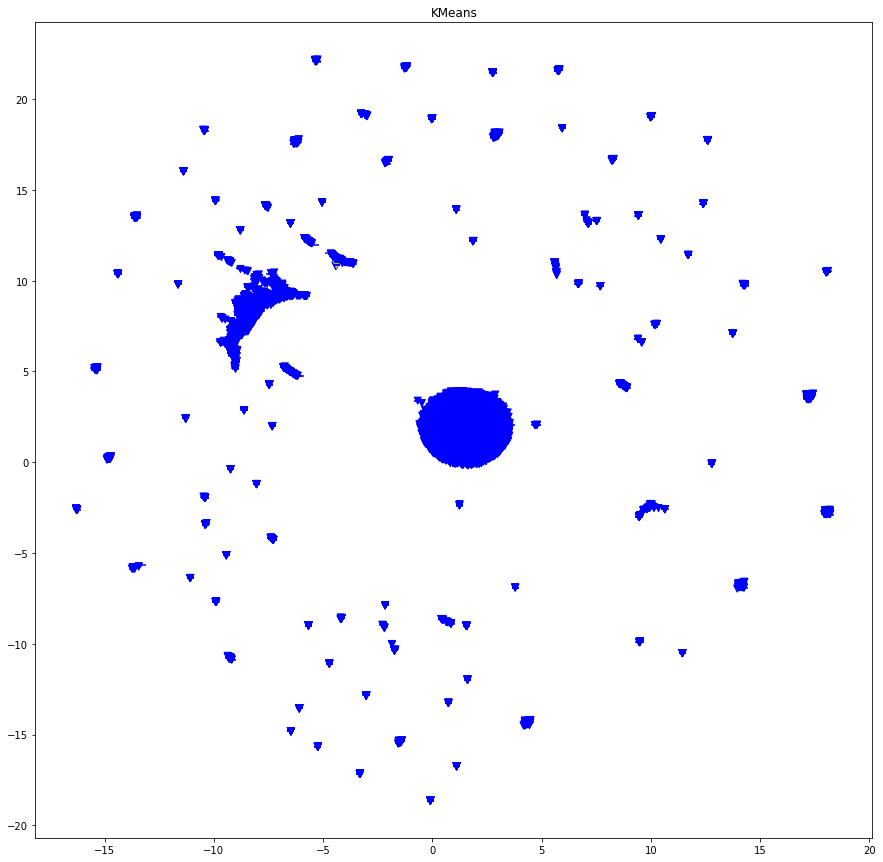

In [154]:

colors = ['b','y']
actual_labels['LABEL'].astype(int)



# marker=[markers[x] for x in actual_labels['LABEL'].astype(int)]
plt.figure(figsize=(15, 15))
# for i in range(len(embedding)):
#     plt.scatter(embedding[i,0], embedding[i,1], 
#                 c = colors[y_pred[i]], 
#                 marker = markers[int(actual_labels['LABEL'][i])])
plt.scatter(true_X['X0'],true_X['X1'],c=[colors[x] for x in true_X['PREDICTED']],marker="v",s=50)
plt.scatter(false_X['X0'],false_X['X1'],c=[colors[x] for x in false_X['PREDICTED']],marker="_",s=50)
#             ,marker=actual_labels['LABEL'].astype(int))
# [markers[x] for x in actual_labels['LABEL'].astype(int)]


plt.title("KMeans")
plt.show()

# l1 = [1,0,1,1,1,1,0,0,1,0,1,0,0,0,1]

# [markers[x] for x in actual_labels['LABEL'].astype(int)]
# actual_labels.head()
# y_pred

In [65]:
type(y_pred)

numpy.ndarray

## Crafts

In [41]:
# // TODO
# feature_filtered_df = labevent_detailed_df[(labevent_detailed_df.LABEL == 'Blasts')] 
labevent_detailed_df[(labevent_detailed_df.LABEL == 'pH')].sort_values(by='SUBJECT_ID')

In [210]:
# initiate all user vectors
con_stc_ls = ['min','mean','max','std']
con_stc_ls_len = len(con_stc_ls)

user_vectors = {}
all_users = set(labevent_detailed_df['SUBJECT_ID'].unique())
for user in all_users:
    user_vectors[user] = np.empty([0])
    

In [213]:
# pick one iteration of continuous label
wbc = labevent_detailed_df[labevent_detailed_df['LABEL']=='WBC']
wbc_agg = wbc.dropna(subset=['VALUENUM']).groupby('SUBJECT_ID')['VALUENUM'].agg(con_stc_ls)
wbc_agg.head()
# wbc_agg[:10]
# wbc[wbc['SUBJECT_ID']==4][:10]

current_users = set(wbc['SUBJECT_ID'].unique())
missed_users = all_users - current_users

for user, row in wbc_agg.iterrows():
    if pd.isnull(row['std']): row['std']=0
    user_vectors[user]=np.append(user_vectors[user],[row[x] for x in con_stc_ls])
for user in missed_users:
    user_vectors[user]=np.append(user_vectors[user],np.full(con_stc_ls_len, np.nan))

In [190]:
# all_users = labevent_detailed_df['SUBJECT_ID'].unique() 
# print(len(set(all_users)- set(wbc['SUBJECT_ID'].unique())))
# print(len(all_users))
# np.full(3, np.nan)
# np.append(np.array([1]),[2,3])
# user_vectors[5]
# wbc = labevent_detailed_df[labevent_detailed_df['LABEL']=='WBC']
ani_agg.head()


Index(['min', 'mean', 'max', 'std'], dtype='object')

In [214]:
# pick one iteration of discrete label
ani = labevent_detailed_df[labevent_detailed_df['LABEL']=='Anisocytosis']
ani_agg = ani.dropna(subset=['VALUE']).groupby(['SUBJECT_ID','VALUE'])['LABEL'].agg(['count'])
ani_agg_per = ani_agg.groupby(level=0).apply(lambda x: 100* x/float(x.sum()))
current_users = set(ani['SUBJECT_ID'].unique())
missed_users = all_users - current_users

ani_agg_per.reset_index
ani_matrix = pd.pivot_table(ani_agg_per,values = ['count'],index=['SUBJECT_ID'],columns=['VALUE'])

ani_matrix = ani_matrix.fillna(0)
for user in ani_matrix.index.get_level_values('SUBJECT_ID')[:10]:
    user_vectors[user] = np.append(user_vectors[user],ani_matrix.ix[user].values)
for user in missed_users:
    user_vectors[user]=np.append(user_vectors[user],np.full(ani_matrix.shape[1], np.nan))
# ani_matrix.head() 
# ani_matrix.shape[1]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  del sys.path[0]


In [203]:
final_feature_df = feature_filtered_df[['SUBJECT_ID','CHARTTIME','VALUENUM']]
# Remove Nan data
final_feature_df = final_feature_df[final_feature_df.VALUENUM.notna()]
final_feature_df[:10]

SUBJECT_ID           CHARTTIME  VALUENUM
54            3 2101-10-14 03:00:00      10.3
94            3 2101-10-15 03:30:00       9.9
129           3 2101-10-16 04:00:00      10.2
192           3 2101-10-22 04:00:00       9.5
360           3 2101-10-23 03:45:00      10.5
415           3 2101-10-20 19:26:00       7.8
450           3 2101-10-20 19:59:00       8.2
523           3 2101-10-20 16:40:00      10.0
600           2 2138-07-17 20:48:00       0.0
619           2 2138-07-17 21:10:00      16.5

In [204]:
final_feature_df['CHAR_DATE'] = final_feature_df['CHARTTIME'].dt.date
final_feature_df[:10]

SUBJECT_ID           CHARTTIME  VALUENUM   CHAR_DATE
54            3 2101-10-14 03:00:00      10.3  2101-10-14
94            3 2101-10-15 03:30:00       9.9  2101-10-15
129           3 2101-10-16 04:00:00      10.2  2101-10-16
192           3 2101-10-22 04:00:00       9.5  2101-10-22
360           3 2101-10-23 03:45:00      10.5  2101-10-23
415           3 2101-10-20 19:26:00       7.8  2101-10-20
450           3 2101-10-20 19:59:00       8.2  2101-10-20
523           3 2101-10-20 16:40:00      10.0  2101-10-20
600           2 2138-07-17 20:48:00       0.0  2138-07-17
619           2 2138-07-17 21:10:00      16.5  2138-07-17

In [205]:

final_feature_bydate_df = final_feature_df.groupby(['SUBJECT_ID','CHAR_DATE']).agg({"VALUENUM": "mean"})

final_feature_bydate_df = final_feature_bydate_df.reset_index().sort_values(by=['SUBJECT_ID','CHAR_DATE'])

final_feature_bydate_df['SHIFT_DATE'] = final_feature_bydate_df.groupby('SUBJECT_ID')['CHAR_DATE'].apply(lambda i:i.shift(1))
final_feature_bydate_df[:10]

SUBJECT_ID   CHAR_DATE   VALUENUM  SHIFT_DATE
0           2  2138-07-17   8.250000         NaN
1           3  2101-10-04  11.500000         NaN
2           3  2101-10-05  11.000000  2101-10-04
3           3  2101-10-06  10.900000  2101-10-05
4           3  2101-10-07  10.600000  2101-10-06
5           3  2101-10-11   9.700000  2101-10-07
6           3  2101-10-14  10.300000  2101-10-11
7           3  2101-10-15   9.900000  2101-10-14
8           3  2101-10-16  10.200000  2101-10-15
9           3  2101-10-20   8.666667  2101-10-16

In [206]:
final_feature_bydate_df['DATE_INTERVAL'] = (final_feature_bydate_df['CHAR_DATE']
                                           - final_feature_bydate_df['SHIFT_DATE']).dt.days

## remove those subjects not in feature dataframe


In [207]:
final_label_df = final_label_df[final_label_df['SUBJECT_ID'].isin(final_feature_bydate_df['SUBJECT_ID'])]

In [208]:
subject_label = {}
subject_label = final_label_df.set_index('SUBJECT_ID').to_dict('index')
for key in subject_label:
    subject_label[key] = subject_label[key]['CONGESTIVE_HEART_FAILURE']

In [209]:
num_attrs = 25
current_vector = np.zeros(num_attrs, dtype=float)
current_index = 0
current_subject = final_feature_bydate_df["SUBJECT_ID"][0]
subject_dict = {}


for index, row in final_feature_bydate_df.iterrows():
    # if not in the begining of a group, increase index by date interval
    if not (pd.isnull(row["DATE_INTERVAL"])):
        current_index += row["DATE_INTERVAL"]
        
    if row["SUBJECT_ID"] != current_subject: 

        subject_dict[current_subject] = current_vector
        current_vector = np.zeros(num_attrs, dtype=float)
        if current_subject not in subject_label:
            subject_label[current_subject]= '0'
        
        current_index = 0
        current_subject = row["SUBJECT_ID"]
        
    if current_index >= 25: continue
    current_vector[int(current_index)]= row["VALUENUM"]

subject_dict[current_subject] = current_vector
if current_subject not in subject_label:
    subject_label[current_subject]='0'

## t-SNE

In [286]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import random

max_train = 5000
train_dict_keys = random.sample(list(subject_dict.keys()), max_train)
## Get X and y
X = np.empty(shape=(max_train,max_attrs))
y = np.empty(shape=(max_train))

i=0
for k in train_dict_keys:
    X[i]=subject_dict[k]
    y[i]=subject_label[k]
    i+=1   
    
X_embedded = TSNE(n_components=2, learning_rate=3000).fit_transform(X)

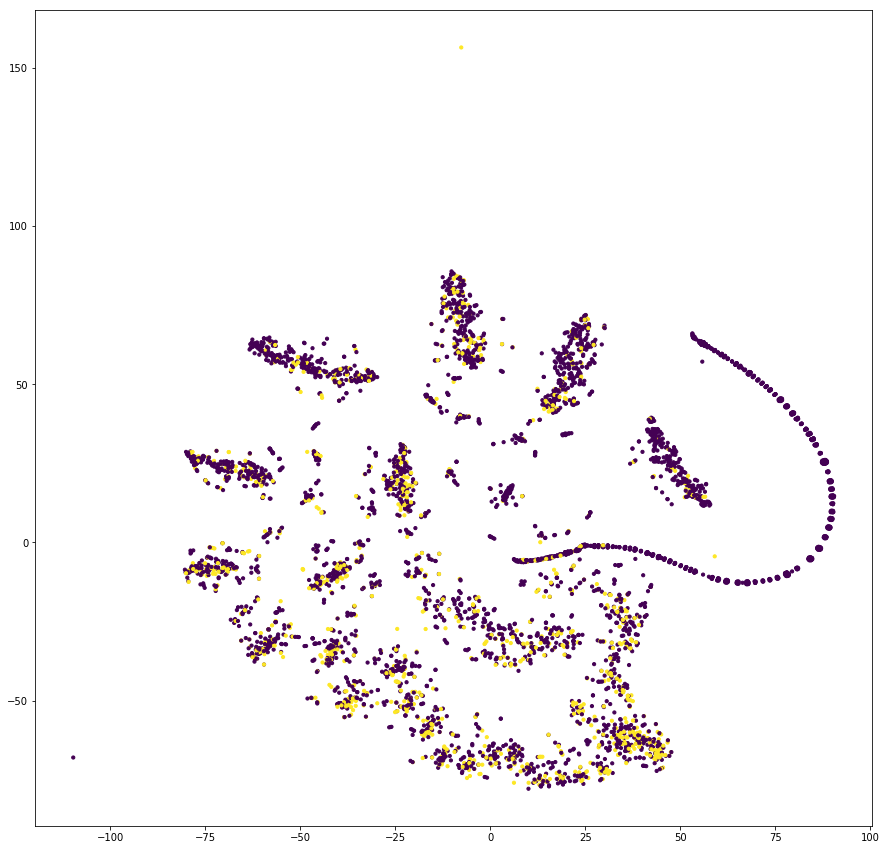

In [287]:
plt.figure(figsize=(15, 15))
plt.scatter(X_embedded[:,0],X_embedded[:,1],c=y, s=10, alpha = 1)

plt.show()